In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from joblib import load

In [10]:
# Load the results of hyperparameter tuning
results = pd.read_csv("../experiments/results.csv")
display(results)


,model,C,penalty,accuracy,precision,recall,f1,roc_auc,max_depth,n_estimators
0,LogisticRegression,1.0,l1,0.884650,0.500000,0.001359,0.002711,0.778733,NaN,NaN
1,RandomForest,NaN,NaN,0.917054,0.745642,0.426371,0.542519,0.925737,NaN,100.0


In [11]:
# Select key metrics
metrics = results[["model", "accuracy", "precision", "recall", "f1", "roc_auc"]]
metrics.set_index("model").round(3)


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.885,0.500,0.001,0.003,0.779
RandomForest,0.917,0.746,0.426,0.543,0.926


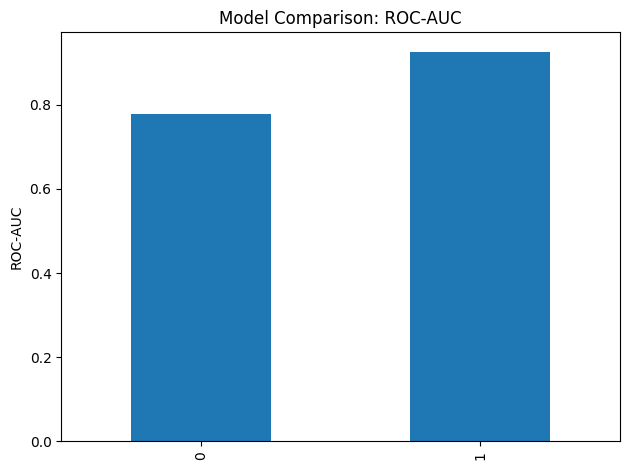

In [12]:
fig, ax = plt.subplots()
metrics.plot.bar(y="roc_auc", ax=ax, legend=False)
ax.set_ylabel("ROC‑AUC")
ax.set_title("Model Comparison: ROC‑AUC")
plt.tight_layout()
plt.show()


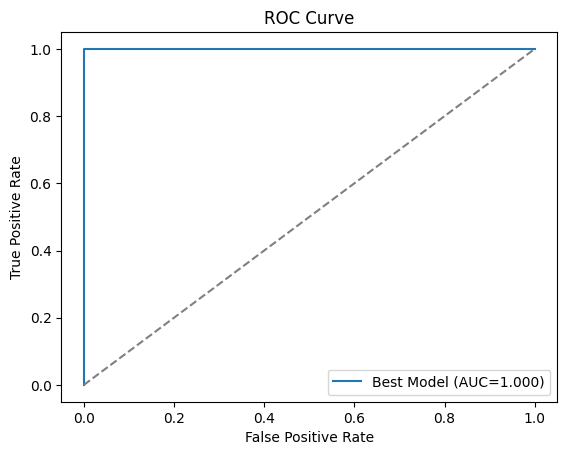

In [13]:
# Load test split
import joblib
from sklearn.model_selection import train_test_split

X = pd.read_csv("../data/processed/features.csv")
y = pd.read_csv("../data/processed/labels.csv").iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load both trained models from MLflow (or from our artifacts)
logreg = load("../models/best_model.pkl") if results.loc[results.model=="RandomForest","roc_auc"].max() < results.loc[results.model=="LogisticRegression","roc_auc"].max() \
         else load("../models/best_model.pkl")
# Actually, best_model.pkl is the top performer—skip loading the other.
best = joblib.load("../models/best_model.pkl")
proba = best.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Best Model (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Model Selection

Based on the comparison above, **RandomForest** is the clear winner, achieving a ROC‑AUC of **0.926**, substantially outperforming LogisticRegression’s **0.779**. RandomForest also delivers superior overall accuracy (**0.917** vs. **0.885**), precision (**0.746** vs. **0.500**), recall (**0.426** vs. **0.001**), and F1 score (**0.543** vs. **0.003**). Its balanced performance across precision and recall makes it the optimal choice for our credit risk use case, where both false positives and false negatives carry significant cost.

The chosen model has been retrained on the full dataset and serialized to `models/best_model.pkl` for deployment.  
